In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook

# Loading the data

In [2]:
_train = pd.read_csv("train.csv")
train = _train.copy()
_test = pd.read_csv("test.csv")
test = _test.copy()

In [3]:
train_len = len(train)
print("Training dataset size = {}".format(train_len))
train.head()

Training dataset size = 891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_len = len(test)
print("Test dataset size = {}".format(test_len))
test.head()

Test dataset size = 418


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Data analysis

Start by analysing the features and how they relate to the passengers survival. Let's start by checking for missing data for each feature.

In [5]:
print('Training set:')
pd.DataFrame({'No. NaN': train.isna().sum(), '%': train.isna().sum() / len(train)})

Training set:


,%,No. NaN
PassengerId,0.000000,0
Survived,0.000000,0
Pclass,0.000000,0
Name,0.000000,0
Sex,0.000000,0
Age,0.198653,177
SibSp,0.000000,0
Parch,0.000000,0
Ticket,0.000000,0
Fare,0.000000,0


In [6]:
print('Test set:')
pd.DataFrame({'No. NaN': test.isna().sum(), '%': test.isna().sum() / len(test)})

Test set:


,%,No. NaN
PassengerId,0.000000,0
Pclass,0.000000,0
Name,0.000000,0
Sex,0.000000,0
Age,0.205742,86
SibSp,0.000000,0
Parch,0.000000,0
Ticket,0.000000,0
Fare,0.002392,1
Cabin,0.782297,327


Features with missing data:
- **Cabin**: ~78% of missing data; drop it.
- **Age**: Decide whether to fill the missing data or not after analysis.
- **Fare**: Very small portion of the data is missing; fill it if he feature is useful.
- **Embarked**: Very small portion of the data is missing; fill it if he feature is useful.

Besides Cabin, drop the PassengerId.

In [7]:
train.drop(columns=['Cabin', 'PassengerId'], inplace=True)
test.drop(columns=['Cabin', 'PassengerId'], inplace=True)

## Age

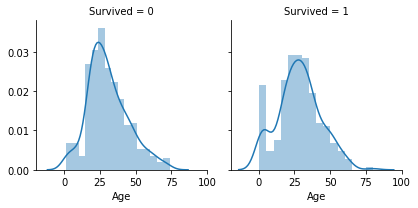

In [8]:
g = sns.FacetGrid(train, col='Survived')
_ = g.map(sns.distplot, 'Age')

In [9]:
age_band_series, age_bins = pd.cut(train['Age'], 10, retbins=True)

survival = (train['Survived'].groupby(age_band_series)
                           .agg(['count', 'sum', 'mean'])
                           .rename(columns={'count': 'Total',
                                            'sum': 'Survived',
                                            'mean': 'Survival Rate'}))
survival

,Total,Survived,Survival Rate
Age,,,
"(0.34, 8.378]",54,36,0.666667
"(8.378, 16.336]",46,19,0.413043
"(16.336, 24.294]",177,63,0.355932
"(24.294, 32.252]",169,65,0.384615
"(32.252, 40.21]",118,52,0.440678
"(40.21, 48.168]",70,24,0.342857
"(48.168, 56.126]",45,21,0.466667
"(56.126, 64.084]",24,9,0.375000
"(64.084, 72.042]",9,0,0.000000


Children (age < 8) have much higher chances of survival. There are also small spikes in survival for passengers in the following bands:
- (32.252, 40.21] - 44.1%
- (48.168, 56.126] - 46.7%

### Filing missing Age values

Use Pclass and Title to fill the missing age values.

In [10]:
# Use both the training and test dataset to fill the missing Age values
fill_age_df = pd.concat([train, test], sort=True)[['Name', 'Age', 'Pclass', 'SibSp', 'Parch', 'Sex']]

# Use the age bins from above
fill_age_df['Age'] = pd.cut(fill_age_df['Age'], age_bins)

# Get the titles of the passengers
fill_age_df['Title'] = fill_age_df['Name'].apply(lambda x: x[x.find(', ') + 1:x.find('.') + 1])

# Now that we have the titles we can drop the names
fill_age_df.drop(columns='Name', inplace=True)

# Encode ages bins and titles in integers 
fill_age_df['Age'] = fill_age_df['Age'].cat.codes
fill_age_df['Title'] = fill_age_df['Title'].astype('category').cat.codes
fill_age_df['Sex'] = fill_age_df['Sex'].astype('category').cat.codes

fill_age_df

,Age,Pclass,SibSp,Parch,Sex,Title
0,2,3,1,0,1,12
1,4,1,1,0,0,13
2,3,3,0,0,0,9
3,4,1,1,0,0,13
4,4,3,0,0,1,12
5,-1,3,0,0,1,12
6,6,1,0,0,1,12
7,0,3,3,1,1,8
8,3,3,0,2,0,13
9,1,2,1,0,0,13


Try three basic classification models to predict the age bands for missing data:
- Logistic regression
- K-nearest neighbors
- Decision tree

In [11]:
X_train = fill_age_df.loc[fill_age_df['Age'] != -1].drop(columns='Age')
Y_train = fill_age_df['Age'].loc[fill_age_df['Age'] != -1]
X = fill_age_df.loc[fill_age_df['Age'] == -1].drop(columns='Age')
print("Training samples shape: {}".format(X_train.shape))
print("Ground-truth shape: {}".format(Y_train.shape))
print("Samples to predict: {}".format(X.shape))

Training samples shape: (1044, 5)
Ground-truth shape: (1044,)
Samples to predict: (265, 5)


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

logreg = LogisticRegression()
logreg_scores = cross_val_score(logreg, X_train, Y_train, cv=3)
print("Logistic Regression cross-validation scores: {}".format(logreg_scores))

knn = KNeighborsClassifier()
knn_scores = cross_val_score(knn, X_train, Y_train, cv=3)
print("KNeighbors cross-validation scores: {}".format(knn_scores))

tree = DecisionTreeClassifier()
tree_scores = cross_val_score(tree, X_train, Y_train, cv=3)
print("Tree Classifier cross-validation scores: {}".format(tree_scores))

Logistic Regression cross-validation scores: [0.29829545 0.29597701 0.30813953]
KNeighbors cross-validation scores: [0.25852273 0.27011494 0.37209302]
Tree Classifier cross-validation scores: [0.34943182 0.31896552 0.38372093]


None of the models manages to have high-accuracy, but they are good at predicting which passengers are children. The per-class/per-age band accuracy confirm this statement - 95.7% accuracy for passengers in the 0 to 8 age band.

It also shows that the model can make good predictions for passengers within the ages of 16 and 24. A possible explanation is that passengers within this age band are more likely to be traveling with friends or alone, therefore SibSp and Parch are 0.

Also note that 0 to 8 years old is the most important age band as discussed previously, thus having a low accuracy overall shouldn't be a big issue as long as we have a high accuracy for that age band.

In [13]:
# Predict
tree.fit(X_train, Y_train)
Y_pred = tree.predict(X_train)

total = np.bincount(Y_train.values, minlength=10)
correct = np.bincount(Y_pred[Y_pred == Y_train.values], minlength=10)
class_acc = correct / total
pd.DataFrame({'Age band': age_band_series.cat.categories, 'Per class acc.': class_acc})

,Age band,Per class acc.
0,"(0.34, 8.378]",0.957143
1,"(8.378, 16.336]",0.274194
2,"(16.336, 24.294]",0.697080
3,"(24.294, 32.252]",0.396000
4,"(32.252, 40.21]",0.254658
5,"(40.21, 48.168]",0.361111
6,"(48.168, 56.126]",0.246154
7,"(56.126, 64.084]",0.097561
8,"(64.084, 72.042]",0.100000
9,"(72.042, 80.0]",0.000000


We can now predict the age band for passengers with missing data:

In [14]:
Y = tree.predict(X)
fill_age_df.loc[fill_age_df['Age'] == -1, 'Age'] = Y

# Just to make sure...these should both be 0 now
print("Number of -1 = {}".format(fill_age_df['Age'].loc[fill_age_df['Age'] == -1].sum()))
print("Number of NaN = {}".format(fill_age_df['Age'].isna().sum()))

Number of -1 = 0
Number of NaN = 0


Apply the integer encoded age bands to the train and test datasets.

In [15]:
train['Age'] = fill_age_df.iloc[:train_len, 0]
test['Age'] = fill_age_df.iloc[train_len:, 0]

train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,2,1,0,A/5 21171,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,4,1,0,PC 17599,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,3,0,0,STON/O2. 3101282,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,4,1,0,113803,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,4,0,0,373450,8.0500,S


## Sex

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

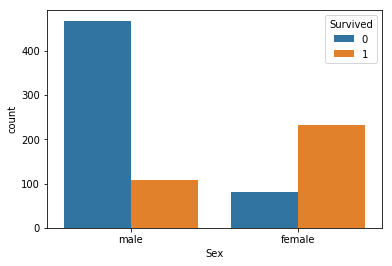

In [16]:
_ = sns.countplot(x='Sex', hue='Survived', data=train)
train.groupby('Sex')['Survived'].mean()

Females have much higher survival rates. One-hot encode `Sex` so the algorithms can handle it.

In [17]:
# One-encode using dummies
train['IsMale'] = pd.get_dummies(train['Sex'], drop_first=True)
test['IsMale'] = pd.get_dummies(test['Sex'], drop_first=True)

# Drop the Sex column
train.drop(columns='Sex', inplace=True)
test.drop(columns='Sex', inplace=True)

## Ticket class (Pclass)

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

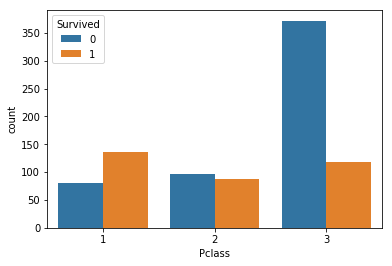

In [18]:
_ = sns.countplot(x='Pclass', hue='Survived', data=train)
train.groupby('Pclass')['Survived'].mean()

Passengers with higher ticket class (lower `Pclass`) have higher chances of survival:
- 1st class: 63%
- 2nd class: 48%
- 3rd class: 24%

Keep the feature as-is, Pclass is already encoded in integers (one-hot encoding would leave out the natural order of ticket class which is an important part of the feature).

## Port of Embarkation (Embarked)

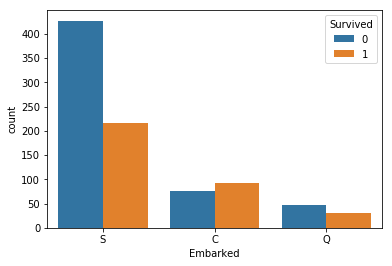

In [19]:
_ = sns.countplot(x='Embarked', hue='Survived', data=train)

After looking at this graph my first thought was that it was a useful feature, we can see that passengers from different ports have varying chances of survival. Great!

Then, after thinking some more I was convinced that there shouldn't be a correlation between port of embarkation and survival. I thought that what this graph shows is just the combination of `IsMale` and `Pclass`...

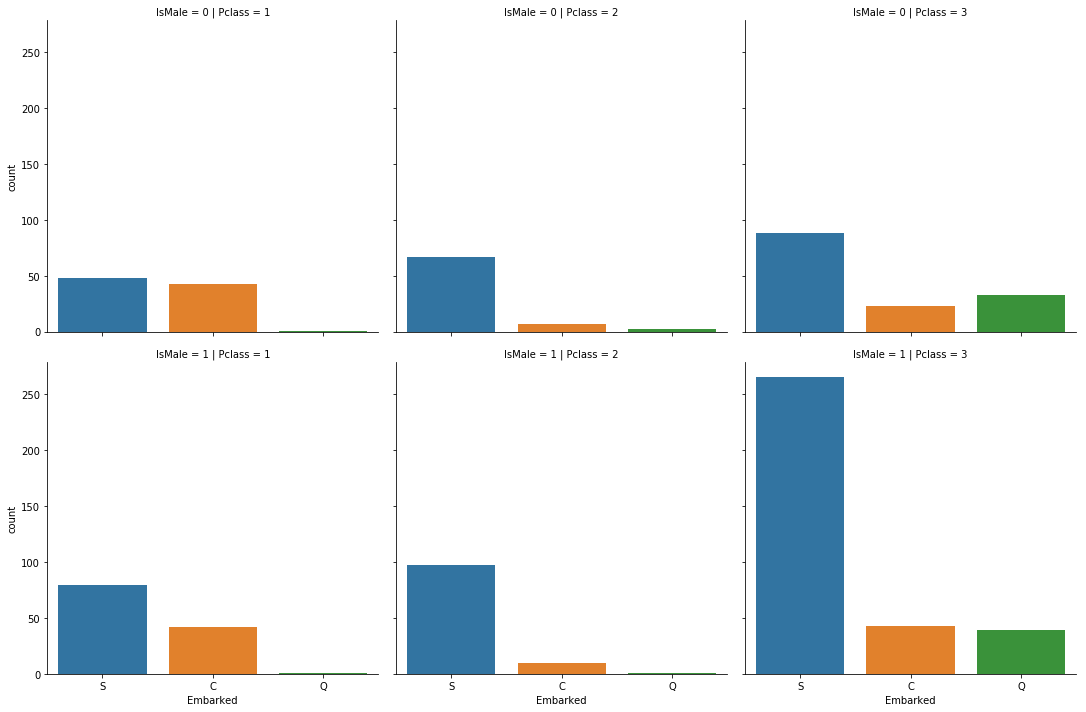

In [20]:
# Plot relationship between Embarked, Pclass, and IsMale
_ = sns.catplot(x='Embarked', col='Pclass', row='IsMale', data=train, kind='count')

In [21]:
# Passengers grouped by Embarked, Pclass, and IsMale
embarked_corr = (train[['Survived', 'Embarked', 'Pclass', 'IsMale']].groupby(['Embarked', 'Pclass', 'IsMale'])                                            
                                                                    .agg(['count', 'sum', 'mean']))
embarked_corr.columns = embarked_corr.columns.droplevel(0)
embarked_corr.columns = ['Total', 'Survived', 'Rate']
embarked_corr

Total  Survived      Rate
Embarked Pclass IsMale                           
C        1      0          43        42  0.976744
                1          42        17  0.404762
         2      0           7         7  1.000000
                1          10         2  0.200000
         3      0          23        15  0.652174
                1          43        10  0.232558
Q        1      0           1         1  1.000000
                1           1         0  0.000000
         2      0           2         2  1.000000
                1           1         0  0.000000
         3      0          33        24  0.727273
                1          39         3  0.076923
S        1      0          48        46  0.958333
                1          79        28  0.354430
         2      0          67        61  0.910448
                1          97        15  0.154639
         3      0          88        33  0.375000
                1         265        34  0.128302

We see that in `Southampton (S)` a high number of 3rd class males embarked the Titanic so a low survival rate is to be expected. A high number of 1st class passengers embarked in `Cherbourg (C)` so we see a high survival rate. In `Queenstown (Q)`, however, the chart shows something that I was not expecting given the following observations:
- the vast majority of passengers are 3rd class passengers;
- the number of males and females is comparable.

Given these conditions, survival rate should be correlated only to `IsMale`, and that is true for females; males however end-up with half the survival rate. Though, this is a sample of 42 males in a population of 577, so it's not enough to convince me that `Embarked` is independently correlated to survival. `Embarked` is dropped.

In [22]:
train.drop(columns='Embarked', inplace=True)
test.drop(columns='Embarked', inplace=True)

## Fare

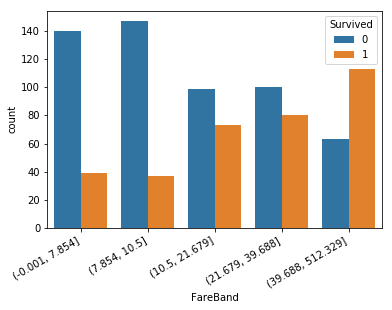

In [23]:
train['FareBand'], fare_bins = pd.qcut(train['Fare'], 5, retbins=True)
_ = sns.countplot(x='FareBand', hue='Survived', data=train)
_ = plt.xticks(rotation=30, ha='right')

One might think that `Fare` and `Pclass` are highly correlated, let's see if that is true... 

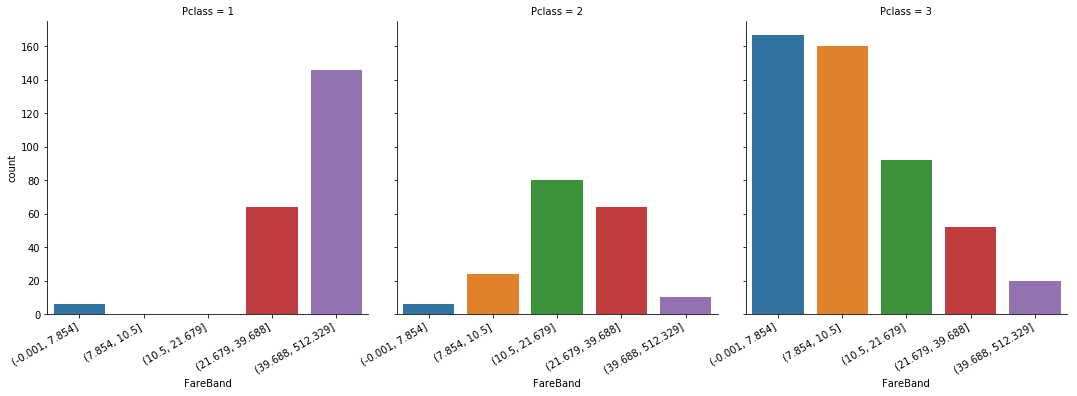

In [24]:
# Plot relationship between FareBand and Pclass
g = sns.catplot(x='FareBand', col='Pclass', data=train, kind='count')
_ = g.set_xticklabels(rotation=30, ha='right')

In [25]:
# Group passengers by FareBand and Pclass
fare_corr = (train[['Survived', 'FareBand', 'Pclass']].groupby(['Pclass', 'FareBand'])
                                                      .agg(['count', 'sum', 'mean']))
fare_corr.columns = fare_corr.columns.droplevel(0)
fare_corr.columns = ['Total', 'Survived', 'Rate']
fare_corr

Total  Survived      Rate
Pclass FareBand                                    
1      (-0.001, 7.854]        6         0  0.000000
       (21.679, 39.688]      64        32  0.500000
       (39.688, 512.329]    146       104  0.712329
2      (-0.001, 7.854]        6         0  0.000000
       (7.854, 10.5]         24         9  0.375000
       (10.5, 21.679]        80        35  0.437500
       (21.679, 39.688]      64        39  0.609375
       (39.688, 512.329]     10         4  0.400000
3      (-0.001, 7.854]      167        39  0.233533
       (7.854, 10.5]        160        28  0.175000
       (10.5, 21.679]        92        38  0.413043
       (21.679, 39.688]      52         9  0.173077
       (39.688, 512.329]     20         5  0.250000

There is correlation, but there is also some unique information that we can observe in `Fare`, particularly for 3rd class passengers:
1. many bought expensive tickets
2. survival is not related to fare, though there is a spike in the 10.5 to 21.7 fare band

Since the majority of passengers are 3rd class I think this information might help to predict who survives and who doesn't.

Fare bands should be encoded as integers since there is a natural order to the feature. Before including it we also need to fill the missing entry in Fare. **Note:** I am only filling after the analysis because the ammount of missing data is not significant.

In [26]:
# Fill missing fares
dataset = pd.concat([train, test], sort=True)
dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)
print("No. of NaN values in Fare: {}".format(dataset['Fare'].isna().sum() / len(train)))

train = dataset.iloc[:train_len].copy()
test = dataset.iloc[train_len:].copy()

No. of NaN values in Fare: 0.0


In [27]:
# Convert fare bands to integers and drop the 'Fare' column
train['FareBand'] = train['FareBand'].astype('category').cat.codes
train.drop(columns='Fare', inplace=True)

# Apply the fare bands computed from the training set, convert to integers and drop the 'Fare' column
test['FareBand'] = pd.cut(test['Fare'], fare_bins)
test['FareBand'] = test['FareBand'].astype('category').cat.codes
test.drop(columns='Fare', inplace=True)

## Enginnering Groups of Passengers (InGroups)

A passenger belongs to a group if he shares one of the following features with at least one other passenger:
1. ticket number;
2. combination of: surname + PClass + ticket number (excluding last digit) + embarked.

Note: Could also take advantage of Parch and SibSp but since errors have been found with those features I won't use them.

In [28]:
# Create the new feature for the whole dataset 
# (I am using _train and _test because train and test no longer contain 'Embarked')
dataset = pd.concat([_train, _test], sort=True)

### Groups by ticket number

In [29]:
# Groups that shares the same ticket number
ticket_count = dataset['Ticket'].value_counts()
shared_tickets = ticket_count[ticket_count > 1].index
group_tickets = dataset['Ticket'].apply(lambda x: x in shared_tickets)

### Groups by surname + PClass + ticket number (excluding last digit) + embarked

In [30]:
surname = dataset['Name'].apply(lambda x: x[:x.find(',')])
ticket = dataset['Ticket'].apply(lambda x: x[:-1])

spte_id = (surname.astype(str) + '-' + dataset['Pclass'].astype(str) + '-'
           + ticket.astype(str) + '-' + dataset['Embarked'].astype(str) + '-' + dataset['Fare'].astype(str))

spte_count = spte_id.value_counts()
shared_spte = spte_count[spte_count > 1].index
group_spte = spte_id.apply(lambda x: x in shared_spte)

### Merging the groups

Add the `InGroup` feature to the `train` and `test` datasets. Also drop the features: `Name`, `SibSp`, `Parch`, and `Ticket`. 

In [31]:
# Merge groups
dataset['InGroup'] = group_tickets | group_spte

# Convert the bool values to ints
train['InGroup'] = dataset.iloc[:train_len, -1].astype(int)
test['InGroup'] = dataset.iloc[train_len:, -1].astype(int)

train.drop(columns=['Name', 'SibSp', 'Parch', 'Ticket'], inplace=True)
test.drop(columns=['Name', 'SibSp', 'Parch', 'Ticket', 'Survived'], inplace=True)

train.head()

,Age,FareBand,IsMale,Pclass,Survived,InGroup
0,2,0,1,3,0.0,0
1,4,4,0,1,1.0,1
2,3,1,0,3,1.0,0
3,4,4,0,1,1.0,1
4,4,1,1,3,0.0,0


InGroup
0    0.283516
1    0.488532
Name: Survived, dtype: float64

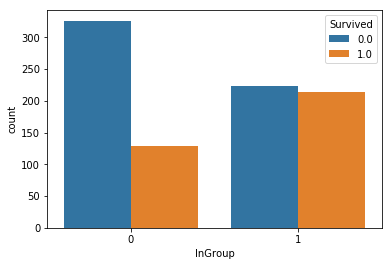

In [32]:
_ = sns.countplot(x='InGroup', hue='Survived', data=train)
train.groupby('InGroup')['Survived'].mean()

Looks like there really is strength in numbers: 49% of the passengers travelling in groups survived while only 28% of the ones travelling alone managed to survive.

# Neural Network with PyTorch

In [35]:
import torch
from sklearn.preprocessing import StandardScaler

# Split the training set into samples and targets
X_train = train.drop(columns='Survived')
Y_train = train['Survived'].astype(int)

# Test set samples to predict
X_test = test

# Scale features such that the mean is 0 and standard deviation is 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the training data to Tensors
X_train_t = torch.Tensor(X_train).cuda()
Y_train_t = torch.Tensor(Y_train).unsqueeze_(-1).cuda()

# Some useful variables
in_dim = X_train_t.size(-1)
hidden_dim = 12
out_dim = 1

# Define the model
model = torch.nn.Sequential(
    torch.nn.Linear(in_dim, hidden_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_dim, hidden_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_dim, hidden_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_dim, hidden_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_dim, out_dim),
    torch.nn.Sigmoid()
).cuda()
model

Sequential(
  (0): Linear(in_features=5, out_features=12, bias=True)
  (1): ReLU()
  (2): Linear(in_features=12, out_features=12, bias=True)
  (3): ReLU()
  (4): Linear(in_features=12, out_features=12, bias=True)
  (5): ReLU()
  (6): Linear(in_features=12, out_features=12, bias=True)
  (7): ReLU()
  (8): Linear(in_features=12, out_features=1, bias=True)
  (9): Sigmoid()
)

In [36]:
# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
for t in range(1000):
    # Forward pass: Compute predicted y by passing x to the model
    Y_pred_t = model(X_train_t)
    
    # Compute and print loss
    loss = loss_fn(Y_pred_t, Y_train_t)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    acc = torch.eq(Y_train_t, Y_pred_t.round_()).cpu().float().mean().numpy()
    print(t, loss.item(), acc)

0 0.747495174407959 0.3838384
1 0.7464891672134399 0.3838384
2 0.7454903721809387 0.3838384
3 0.7444964647293091 0.3838384
4 0.7435035705566406 0.3838384
5 0.742518424987793 0.3838384
6 0.7415410876274109 0.3838384
7 0.7405754327774048 0.3838384
8 0.7396124601364136 0.3838384
9 0.7386507391929626 0.3838384
10 0.7376847267150879 0.3838384
11 0.7367131114006042 0.3838384
12 0.7357283234596252 0.3838384
13 0.7347365617752075 0.3838384
14 0.7337425351142883 0.3838384
15 0.7327460050582886 0.3838384
16 0.731748640537262 0.3838384
17 0.7307417988777161 0.3838384
18 0.729728102684021 0.3838384
19 0.7287080883979797 0.3838384
20 0.7276835441589355 0.3838384
21 0.726655125617981 0.3838384
22 0.7256186604499817 0.3838384
23 0.724571168422699 0.3838384
24 0.7235156893730164 0.3838384
25 0.7224528789520264 0.3838384
26 0.7213943004608154 0.3838384
27 0.7203282713890076 0.3838384
28 0.7192586660385132 0.3838384
29 0.7181779146194458 0.3838384
30 0.7170854210853577 0.3838384
31 0.7159803509712219 0.

291 0.41022393107414246 0.81593716
292 0.4099409878253937 0.81593716
293 0.40965551137924194 0.81593716
294 0.4093692898750305 0.81593716
295 0.4090874195098877 0.81593716
296 0.4088083505630493 0.81593716
297 0.40854504704475403 0.81593716
298 0.40828371047973633 0.81593716
299 0.4080284535884857 0.81593716
300 0.40777045488357544 0.8215488
301 0.407511830329895 0.8215488
302 0.40725287795066833 0.8215488
303 0.4069996178150177 0.8215488
304 0.40675225853919983 0.8215488
305 0.4065072238445282 0.8215488
306 0.40625911951065063 0.8215488
307 0.4060092568397522 0.8215488
308 0.40576279163360596 0.8215488
309 0.40552031993865967 0.8215488
310 0.40527692437171936 0.8260382
311 0.4050322473049164 0.8260382
312 0.40478530526161194 0.8260382
313 0.40453478693962097 0.8260382
314 0.40428125858306885 0.8260382
315 0.40402910113334656 0.8260382
316 0.403781533241272 0.8260382
317 0.40353256464004517 0.8260382
318 0.4032813012599945 0.8260382
319 0.403037428855896 0.8237935
320 0.402792066335678

585 0.36462950706481934 0.8439955
586 0.3645678460597992 0.8439955
587 0.36450380086898804 0.8439955
588 0.3644421398639679 0.84511787
589 0.36437252163887024 0.84511787
590 0.36430418491363525 0.84511787
591 0.3642435669898987 0.84511787
592 0.36417528986930847 0.84511787
593 0.36411401629447937 0.8439955
594 0.3640482723712921 0.84511787
595 0.36397987604141235 0.84511787
596 0.36392489075660706 0.84511787
597 0.36386364698410034 0.84511787
598 0.3637983798980713 0.84511787
599 0.36374080181121826 0.84624016
600 0.36367329955101013 0.84624016
601 0.36361533403396606 0.84511787
602 0.3635503649711609 0.84511787
603 0.363491952419281 0.84511787
604 0.36343392729759216 0.84624016
605 0.3633730113506317 0.84624016
606 0.3633086383342743 0.84624016
607 0.3632510304450989 0.84624016
608 0.3631910979747772 0.84624016
609 0.3631301820278168 0.84624016
610 0.36307281255722046 0.84624016
611 0.36301344633102417 0.84624016
612 0.362956702709198 0.84624016
613 0.36289751529693604 0.84624016
614 

871 0.34852635860443115 0.84960717
872 0.34852099418640137 0.84960717
873 0.3485005497932434 0.84960717
874 0.34844356775283813 0.84960717
875 0.3484242856502533 0.84960717
876 0.34840112924575806 0.84960717
877 0.3483560085296631 0.84960717
878 0.34832364320755005 0.84960717
879 0.348323792219162 0.84960717
880 0.34828469157218933 0.8518519
881 0.34823518991470337 0.84960717
882 0.34821975231170654 0.84960717
883 0.3481849133968353 0.84960717
884 0.3481464087963104 0.84960717
885 0.3481408357620239 0.84960717
886 0.3481020927429199 0.84960717
887 0.3480851650238037 0.84960717
888 0.3480386734008789 0.84960717
889 0.34802505373954773 0.84960717
890 0.3480145037174225 0.8518519
891 0.34794676303863525 0.84960717
892 0.34794285893440247 0.84960717
893 0.3478958010673523 0.84960717
894 0.3478797674179077 0.8518519
895 0.3478471040725708 0.8518519
896 0.3478209376335144 0.8518519
897 0.3477996289730072 0.84960717
898 0.3477592170238495 0.84960717
899 0.3477266728878021 0.8518519
900 0.3477